In [9]:
import pandas as pd 
import numpy as np
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [10]:
company = 'TSLA'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2021, 1, 1)

data = web.DataReader(company, 'yahoo', start, end)

In [11]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [12]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))

In [13]:
#build the Model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
69/69 [==============================] - 17s 122ms/step - loss: 0.0027
Epoch 2/25
69/69 [==============================] - 8s 111ms/step - loss: 0.0011
Epoch 3/25
69/69 [==============================] - 7s 108ms/step - loss: 7.3037e-04
Epoch 4/25
69/69 [==============================] - 8s 118ms/step - loss: 9.6719e-04
Epoch 5/25
69/69 [==============================] - 7s 106ms/step - loss: 9.1919e-04
Epoch 6/25
69/69 [==============================] - 8s 114ms/step - loss: 8.2905e-04
Epoch 7/25
69/69 [==============================] - 7s 106ms/step - loss: 8.3300e-04
Epoch 8/25
69/69 [==============================] - 7s 108ms/step - loss: 5.6960e-04
Epoch 9/25
69/69 [==============================] - 8s 114ms/step - loss: 6.9063e-04
Epoch 10/25
69/69 [==============================] - 8s 114ms/step - loss: 6.6249e-04
Epoch 11/25
69/69 [==============================] - 8s 111ms/step - loss: 4.7347e-04
Epoch 12/25
69/69 [==============================] - 7s 108ms/step - l

- Testing the model accuracy on existing data

In [16]:
# load Test Data
test_start = dt.datetime(2021, 1, 1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [18]:
# Make prediction on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

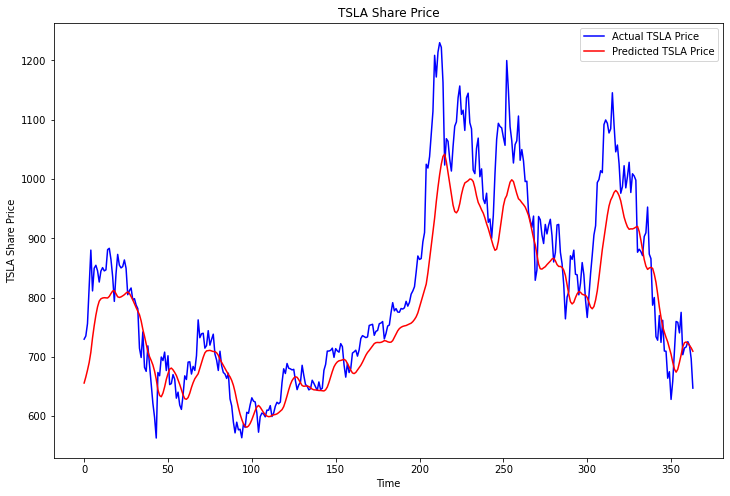

In [31]:
#Plot the test prediction
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color='blue', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='red', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [29]:
# Predict Next day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f'Prediction : {prediction}')

Prediction : [[699.08185]]
